In [1]:
import os
import shutil
import random
# Cargar categorias y dividir el dataset
splitsize = .7
categories = []
source = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/"
folders = os.listdir(source)


for subfolder in folders:
    if os.path.isdir(source + subfolder):
        categories.append(subfolder)
categories.sort()
print(categories)

# Create dataset
target_folder = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset"
existDatasetPath = os.path.exists(target_folder)
if not existDatasetPath:
    os.mkdir(target_folder)

# split data train and test


def split_data(SOURCE, TRAINING, TEST, SPLIT_SIZE):
    files = []

    for filename in os.listdir(SOURCE):
        file = SOURCE + "/" + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is empty")
    print(len(files))
    print(SPLIT_SIZE)
    trainingLength = round(len(files) * SPLIT_SIZE)
    shuffleSet = random.sample(files, len(files))
    trainingSet = shuffleSet[0:trainingLength]
    testSet = shuffleSet[trainingLength:]

    # copy train images
    for filename in trainingSet:
        thisFile = SOURCE + filename
        destination = TRAINING + filename
        shutil.copyfile(thisFile, destination)

    # copy test images
    for filename in testSet:
        thisFile = SOURCE + filename
        destination = TEST + filename
        shutil.copyfile(thisFile, destination)


trainPath = target_folder + "/train"
testPath = target_folder + "/test"

# create target folders
existTrainPath = os.path.exists(trainPath)
if not existTrainPath:
    os.mkdir(trainPath)

existTestPath = os.path.exists(testPath)
if not existTestPath:
    os.mkdir(testPath)

for category in categories:
    trainDestPath = trainPath + "/" + category
    testDestPath = testPath + "/" + category

    if not os.path.exists(trainDestPath):
        os.mkdir(trainDestPath)
    if not os.path.exists(testDestPath):
        os.mkdir(testDestPath)

    sourcePath = source + category + "/"
    trainDestPath = trainDestPath + "/"
    testDestPath = testDestPath + "/"

    print("Copy from: " + sourcePath + " to: " +
          trainDestPath + " " + testDestPath)
    split_data(sourcePath, trainDestPath, testDestPath, splitsize)

['cyclocephala_lunulata', 'dysdercus_concinnus', 'leptinotarsa_decemlineata']
Copy from: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/ to: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/train/cyclocephala_lunulata/ /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/test/cyclocephala_lunulata/
157
0.7
Copy from: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/ to: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/train/dysdercus_concinnus/ /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/test/dysdercus_concinnus/
167
0.7
Copy from: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/ to: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/train/leptinotarsa_decemlineata/ /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/test/leptinotarsa_decem

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

trainPath = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/train"
testPath = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/test"


# 1. Ajustar la Aumentación de Datos
# Este bloque de código crea generadores de datos que cargan imágenes desde los directorios y aplican transformaciones en tiempo real. Esto ayuda a aumentar la diversidad del conjunto de entrenamiento y a prevenir el sobreajuste.

# El trainGenerator aplica varias transformaciones aleatorias:
# - rotation_range: Gira las imágenes hasta 10 grados.
# - width_shift_range: Desplaza las imágenes horizontalmente hasta un 10%.
# - height_shift_range: Desplaza las imágenes verticalmente hasta un 10%.
# - brightness_range: Ajusta el brillo entre 80% y 120%.
# - horizontal_flip: Voltea las imágenes horizontalmente.
# - zoom_range: Realiza un zoom aleatorio hasta un 10%.
trainGenerator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2)
).flow_from_directory(trainPath, target_size=(320, 320), batch_size=32)

# El generador de prueba no aplica transformaciones, ya que queremos evaluar el rendimiento del modelo en los datos originales y sin modificar.
testGenerator = ImageDataGenerator().flow_from_directory(
    testPath, target_size=(320, 320), batch_size=32)

# 2. Construir el modelo
# Aquí se define la arquitectura de la red neuronal que se va a entrenar.
# Se utiliza un modelo pre-entrenado (EfficientNetB0) y se le añaden nuevas capas.

baseModel = EfficientNetB0(weights="imagenet", include_top=False)
x = baseModel.output
x = GlobalAveragePooling2D()(x)  # 1
# Se añaden capas densas personalizadas para la clasificación.
# Se incluye 'Dropout' para apagar aleatoriamente algunas neuronas, lo que ayuda a prevenir el sobreajuste al forzar a la red a no depender de una sola neurona.
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

# Esta es la capa de salida final, que clasifica las imágenes en el número de categorías definidas. La función 'softmax' se utiliza para problemas de clasificación multiclase.
predictionLayer = Dense(len(categories), activation="softmax")(x)

# Se crea el modelo completo, combinando las entradas de EfficientNet con nuestras capas de salida.
model = Model(inputs=baseModel.input, outputs=predictionLayer)


# 3. Congelar las capas de EfficientNet-B0
# Congelar las capas significa que sus pesos no se actualizarán durante el entrenamiento.
# Esto es esencial en el 'transfer learning', ya que aprovechamos el conocimiento que el modelo ya ha adquirido de un gran conjunto de datos. Solo entrenamos nuestras nuevas capas densas.
for layer in baseModel.layers:
    layer.trainable = False

# 4. Compilar y entrenar el modelo
# En este paso, se configura el proceso de entrenamiento.

# Se utiliza el optimizador Adam, que ajusta los pesos de la red de manera eficiente.
# El 'learning_rate' (tasa de aprendizaje) determina qué tan rápido se actualizan los pesos.
optimizer = Adam(learning_rate=0.001)
# Se compila el modelo con la función de pérdida 'categorical_crossentropy' (ideal para clasificación multiclase), el optimizador y la métrica de 'accuracy' (precisión).
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]
              )

# 5. Añadir EarlyStopping y Learning Rate Scheduler como callbacks
# Los callbacks son herramientas que se ejecutan durante el entrenamiento para automatizar ciertas acciones y mejorar el proceso.

# EarlyStopping: Monitorea la pérdida de validación ('val_loss'). Si la pérdida no mejora durante 5 épocas (patience=5), el entrenamiento se detiene automáticamente 'restore_best_weights=True' asegura que el modelo se quede con los mejores pesos obtenidos, no los de la última época.
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# ReduceLROnPlateau: Reduce la tasa de aprendizaje si la pérdida de validación deja de mejorar. Esto ayuda a que el modelo no se estanque en un mínimo local.
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6
)

print("--- Fase 1: Entrenando solo las capas superiores ---")
# Se inicia el entrenamiento del modelo. Se le pasa el generador de entrenamiento, el generador de validación, el número máximo de épocas y los callbacks. 
# La variable 'history_model' guarda el historial de métricas de cada época.
history_phase1 = model.fit(
    trainGenerator,
    validation_data=testGenerator,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

# 6. Descongelar algunas capas de EfficientNet-B0 y fine-tuning (Fase 2)
# Esta fase ajusta los pesos del modelo base para que se adapten mejor a los datos.
# Es especialmente útil si el conjunto de datos es grande o las clases son muy específicas.

print("--- Fase 2: Fine-tuning de capas superiores del modelo base ---")
# Se descongelan las últimas 30 capas del modelo base. 
# Es importante no descongelar todas las capas, ya que las primeras se especializan en características genéricas (bordes, texturas).
for layer in baseModel.layers[-30:]:
    layer.trainable = True

# Es crucial recompilar el modelo después de cambiar la propiedad 'trainable' de las capas.
# Se usa un 'learning_rate' muy bajo para evitar que los pesos pre-entrenados del modelo base se modifiquen drásticamente.
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)

# Se continúa el entrenamiento. Las métricas de esta fase se guardan en 'history_phase2'.
history_phase2 = model.fit(
    trainGenerator,
    validation_data=testGenerator,
    epochs=20,  # O más si el modelo lo requiere
    callbacks=[early_stopping, lr_scheduler]
)

print("Entrenamiento completado.")


# 7. Visualizar las métricas de entrenamiento
# Se combinan los historiales de las dos fases para obtener un gráfico completo.
combined_history = {}
for key in history_phase1.history.keys():
    combined_history[key] = history_phase1.history[key] + \
        history_phase2.history[key]
    

plt.figure(figsize=(12, 6))

# Se grafica la precisión del entrenamiento y la validación para ver si el modelo está generalizando correctamente.
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(combined_history['val_accuracy'], label='Precisión en Validación')
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

# Se grafica la pérdida del entrenamiento y la validación para identificar el sobreajuste.
plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Pérdida en Entrenamiento')
plt.plot(combined_history['val_loss'], label='Pérdida en Validación')
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.tight_layout()
plt.show()

# Guardar modelo
saveModelPath = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/ModelEfficientNetB0.keras"
model.save(saveModelPath)

Found 371 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
--- Fase 1: Entrenando solo las capas superiores ---


c:\Users\santi\anaconda3\envs\semillero\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5983 - loss: 0.7648 - val_accuracy: 0.9873 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9837 - loss: 0.0630 - val_accuracy: 1.0000 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9921 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9988 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 8.2588e-04 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9917 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 8.0645e-04 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0028 - val_ac

In [7]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np

#Predict Image
def classify_image(IMG_PATH):
    x=[]
    img = Image.open(IMG_PATH)
    img.load()
    img = img.resize((320,320), Image.LANCZOS)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    return pred[0]

In [8]:
img_paths = [
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/cyclocephala_lunulata (34).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/dysdercus_concinnu (65).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/leptinotarsa_decemlineata (98).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/cyclocephala_lunulata (3).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/dysdercus_concinnu (45).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/leptinotarsa_decemlineata (10).jpeg"
]

predictions = []
for path in img_paths:
    print(path)
    predictions.append(classify_image(path))

/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/cyclocephala_lunulata (34).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/dysdercus_concinnu (65).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/leptinotarsa_decemlineata (98).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/cyclocephala_lunulata (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/dysdercus_concinnu (45).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/leptinotarsa_decemlineata (10).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


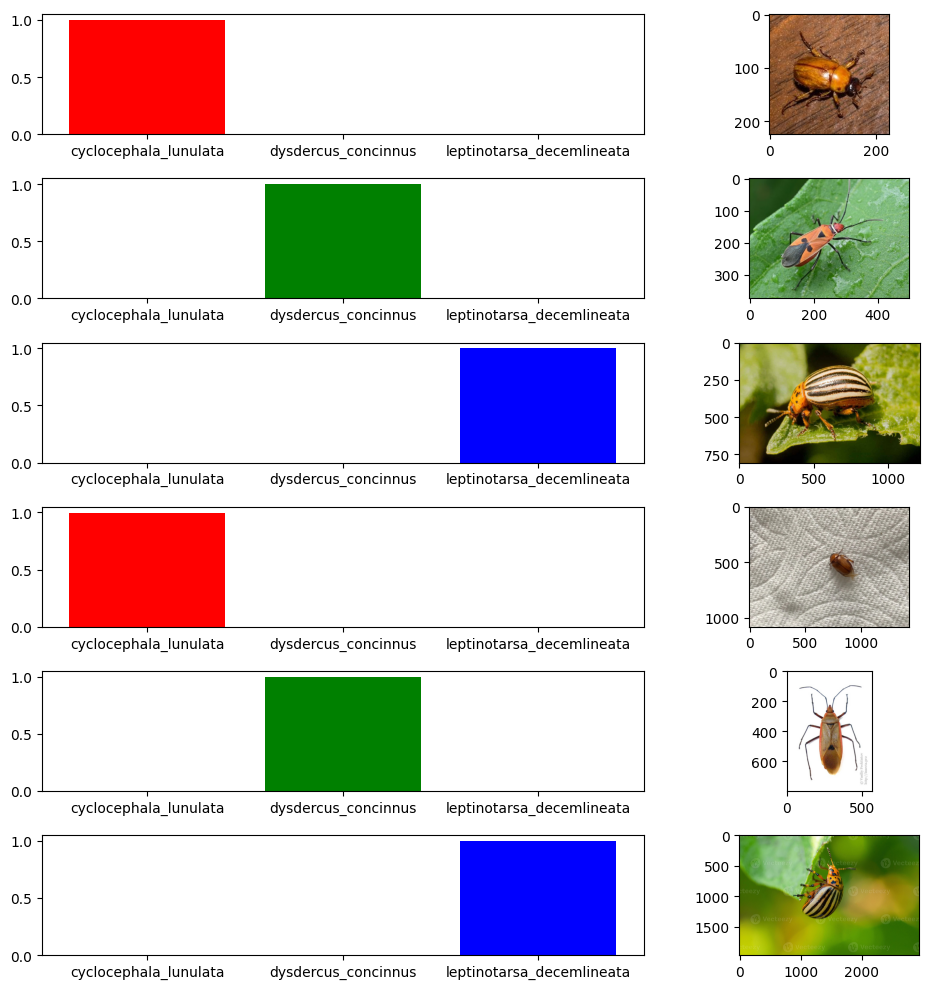

In [9]:
fig,axs = plt.subplots(len(predictions), 2, figsize=(10, 10), gridspec_kw={'width_ratios': [2, 1]})

plotIndex = 1
for i, pred in enumerate(predictions):
    plt.subplot(len(predictions), 2, plotIndex)
    plt.bar(categories, pred, color=['red', 'green', 'blue'])

    plt.subplot(len(predictions), 2, plotIndex+1)
    img = plt.imread(img_paths[i])
    plt.imshow(img)
    plotIndex += 2

fig.tight_layout()
plt.show()